# Code for Figures

In [53]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import chi2, entropy
from collections import Counter
from typing import NamedTuple, Optional
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import squareform
from scipy.stats import linregress,spearmanr,ttest_ind
import warnings
import seaborn as sb
from matplotlib.patches import Rectangle
from labellines import labelLine, labelLines

from utils import rolling_window, flatten

import vlmc

sb.set_theme(style="ticks", context="paper")

## Load Data

In [54]:
class Rep(NamedTuple):
    tree: vlmc.VLMC
    clan: str
    unit: str

dominica_data = pd.read_csv("Data/dominica_coda_data.csv")
# pacific_data = pd.read_excel('Data/ETP.xlsx')

paper_data = pd.read_csv("Data/pacific_coda_data.csv")
paper_data = paper_data[~paper_data["clan_name"].isna()]
paper_data["year"] = paper_data.date.str[:4]

/home/leitao/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Compute subcoda trees

In [125]:
def fitVlmc(df, click_col, horizon=1, resolution=0.02, K=None):
    ICIs = df.filter(regex=("^ICI")).values
    nClicks = df[click_col].values
    codas = [coda[: stop - 1] for coda, stop in zip(ICIs, nClicks)]
    discrete_codas, n_bins = vlmc.bin_codas(
        codas, horizon=horizon, resolution=resolution
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tree = vlmc.VLMC(n_bins + 1).fit(discrete_codas, K=K)
    return tree, discrete_codas


def get_D(TREES):
    """
    Given a set of subcoda trees, compute a distace matrix
    """
    D = np.zeros(shape=(len(TREES), len(TREES)))
    for i in range(len(TREES)):
        for j in range(len(TREES)):
            if i == j:
                distance = 0
            else:
                distance = vlmc.distance(TREES[i], TREES[j])
            D[i, j] = distance
    return D


def getV(C, colors, method="average"):
    """
    compute agglomerative clustering and return most
    aesthetic ordering of leaves.
    """
    s = sb.clustermap(
        C,  # np.maximum(quack.C,quack.C.T)
        row_colors=colors,
        method=method,
        row_cluster=True,
        col_cluster=False,
    )
    s.ax_heatmap.remove()
    s.cax.remove()
    V = s.dendrogram_row.linkage
    row_indexes = s.dendrogram_row.reordered_ind
    plt.close()
    return V, row_indexes


def prune_repertoires(clan_name, threshold=120):
    significant_repertoires = []
    df = paper_data[paper_data["clan_name"] == clan_name].copy().reset_index(drop=True)
    df["latitude"] = pd.to_numeric(df["latitude"])
    df["repertoire_name"] = df["grpvar"]
    
    for repertoire_name, frame in df.groupby("repertoire_name"):
        if len(frame)>threshold:
            significant_repertoires.append(repertoire_name)
    return df[df["repertoire_name"].isin(significant_repertoires)]
    
        

In [126]:
identity_codas = {
    "PALI": [48, 411, 412, 73, 711, 82, 94, 95, 102],
    "FP": [611, 614],
    "SI": [39, 413, 69],
    "RI": [45, 715],
    "SH": [313],
    "PO": [515, 68, 613, 79, 712, 89],
    "REG": [51, 512, 62, 71, 74, 81, 92, 96, 108],
}

pacific_repertoires = []
for clan in identity_codas.keys():
    for rep, frame in prune_repertoires(clan).groupby("repertoire_name"):
        if len(frame) < 25:
            continue
        tree, _ = fitVlmc(frame, click_col="nclicks")
        pacific_repertoires.append(
            Rep(
                tree=tree,
                clan=clan,
                unit=rep,
            )
        )

dominica_repertoires = []
for unit in dominica_data["Unit"].unique():
    if unit == "ZZZ":
        continue
    df = dominica_data[dominica_data["Unit"] == unit]
    tree, _ = fitVlmc(df, click_col="nClicks")
    dominica_repertoires.append(
        Rep(
            tree=tree,
            clan=df["Clan"].unique()[0],
            unit=unit,
        )
    )
    
pacific_distances = get_D([r.tree for r in pacific_repertoires])
dominica_distances = get_D([r.tree for r in dominica_repertoires])

## Plotting functions

In [121]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from matplotlib.transforms import Affine2D
from scipy.stats import ks_2samp
from scipy.cluster import hierarchy

##SVG markers
whale_svg = "M478.491 206.354c-.2-27.681-8.37-52.625-26.592-73.846-18.092-21.068-41.6-32.291-68.668-35.743-21.766-2.775-43.446.059-64.881 4.3-45.638 9.032-85.086 30.364-120.159 60.453q-40.327 34.6-80.893 68.915c-9.692 8.229-20.717 11.321-32.934 6.829-20.755-7.63-27.729-27.881-16.252-47.479 8.228-14.048 16.982-27.792 25.7-41.547a5.648 5.648 0 0 1 4.53-2.117c7.392 1 14.772 2.2 22.069 3.746 21.987 4.658 42.15 1.156 59.1-14.145C190.6 125.706 201.122 115 211.3 104.042c7.347-7.907 3.166-18.72-7.485-20.555Q174.841 78.5 145.8 73.873c-3.176-.5-4.315-1.62-4.82-4.873-2.979-19.2-6.269-38.349-9.454-57.515-.888-5.342-3.567-9.113-8.925-10.9-5.26-1.754-8.9.671-12.386 4.1-9.372 9.21-18.979 18.188-28.176 27.569C68.4 46.169 61.432 62.671 64.153 82.446c1.651 12 3.738 23.934 5.314 35.939a8.006 8.006 0 0 1-1.937 5.884c-10.9 10.975-22.51 21.281-32.93 32.681-7.788 8.521-15.224 17.743-20.894 27.743C.441 208.086-2.88 233.428 2.382 259.843c8.194 41.137 32.185 69.888 69.448 88.026 16.6 8.079 34.5 10.815 52.76 10.878 46.247.161 92.5.054 138.743.054q70.369 0 140.74-.032c17.066-.034 32.919-4.424 46.559-15.007 19.065-14.792 27.642-34.832 27.847-58.572q.341-39.415.012-78.836Zm-179.485 38.851c-9.827-.185-18.214-8.666-18-18.205.216-9.73 8.724-18.007 18.361-17.86a18.31 18.31 0 0 1 17.679 17.968c.044 9.777-8.429 18.279-18.04 18.097Z"
whale_svg = "M0 10.05C5.738 5.992 11.65 6.2 17.715 7.434c4.393.7 4.469 5.78 5.974 9.086 6.955 19.183 28.924 27.03 46.718 33.4-3.142 3.762-4.424 10.449 2.593 8.664C78.56 57 83.026 52.058 89.035 52.67c9.754.663 19.591.35 29.368.208 7.62.843 16.386-1.88 16.07-10.958 1.2-15.32-11.641-11.682-22.191-13.123-17.477-.99-35.219-1.724-52.066-6.811-10.4-8.563-13.527 3.651-28.937-11.651C27.926 8.708 29.714 5 26.524 3.443c-3.567-1.1-7.546-3.6-11.2-3.435-.572 2.211-2.311.951-3.509 1.3C7.263 3.319.489 3.709 0 10.05Z"


##COLORS
desat_color = {
    "PALI": "#FFDFC0",
    "FP": "#F3E5F3",  # EE4FCB
    "SI": "#D7D1E2",
    "RI": "#F3EBC0",
    "SH": "#ECC8C8",
    "PO": "#D0DBFB",
    "REG": "#E6F3CC",
    "EC1": "#D0DBFB",
    "EC2": "#E6F3CC",
}
clan_color = {
    "PALI": "#FF7F00",
    "FP": "#CD96CD",  # EE4FCB
    "SI": "#5D478B",
    "RI": "#CDAD00",
    "SH": "#B22222",
    "PO": "#436EEE",
    "REG": "#9ACD32",
    "EC1": "#436EEE",
    "EC2": "#9ACD32",
}
clan_name = {
    "PALI": "Palindrome",
    "FP": "Four Plus",
    "SI": "Slow Increasing",
    "RI": "Rapid Increasing",
    "SH": "Short",
    "PO": "Plus One",
    "REG": "Regular",
    "EC1": "EC1",
    "EC2": "EC2",
}

def get_marker(svg, rotate=True):
    """
    Function to load svg marker
    """
    marker = parse_path(svg)
    marker.vertices -= marker.vertices.mean(axis=0)
    if rotate:
        marker = marker.transformed(Affine2D().rotate_deg(180))
    return marker

def plot_stripe(clan_label, clan_color, row_indexes, ax=None):
    """
    Plot a string of colors, for showing leaf memebership in dendogram.
    """
    colors = [clan_color[clan] for clan in [clan_label[i] for i in row_indexes]]

    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 0.3))
    max_width = len(row_indexes)

    ax.set_xlim(0, max_width)
    ax.set_ylim(0, 0.1)
    for i, color in enumerate(colors):
        ax.add_patch(Rectangle(xy=(i, 0), width=1, facecolor=color, height=0.1))
    ax.axis("off")
    
    

def inner_outer(reps, click_dist):
    """
    plot to compare distribution of distances between
    elements of the same clan and distances between 
    elements of different clans
    """
    position = 0
    clans = np.unique([r.clan for r in reps])
    values, positions, labels = [], [], []
    stats = {'ks_test':[],'t_test':[],'cohen_d':[],'clan':[]}
    for clan in clans:
        mask = np.array([r.clan == clan for r in reps])
        inner = click_dist[mask, :][:, mask].flatten()
        outer = np.r_[
            click_dist[mask, :][:, ~mask].flatten(),
            click_dist[~mask, :][:, mask].flatten(),
        ]
        
        
        _, p = ks_2samp(inner, outer)
        stats['ks_test'].append(p)
        _, p = ttest_ind(inner,outer)
        stats['t_test'].append(p)
        stats['cohen_d'].append(cohen_d(inner,outer))
        stats['clan'].append(clan_name[clan])
        values.extend([inner, outer])
        positions.extend([position + 1, position + 2])
        labels.extend([clan + "_within", clan + "_between"])
        position += 3
    return values, positions, labels, stats


def inner_outer_plot(repertoires, distances, ax):
    values, positions, labels, pees = inner_outer(repertoires, distances)
    ax.boxplot(values, labels=labels, positions=positions)
    ax.set_xlabel("Clan Name")
    ax.set_ylabel("Vocal Style Difference")
    
from scipy.spatial.distance import squareform
def hierachical_plot(repertoires, D, axs, title="Clan Names"):
    """
    Aux function to plot hierachical plots
    """
    V, row_indexes = getV(np.maximum(D, D.T), [clan_color[r.clan] for r in repertoires])
    clans = np.unique([r.clan for r in repertoires])
    hierarchy.set_link_color_palette(list(clan_color.values()))
    dn = hierarchy.dendrogram(
        V, color_threshold=0.1, above_threshold_color="black", ax=axs[0]
    )
    axs[0].set_title(title)
    axs[0].set_ylabel("VLMC distance")
    axs[0].spines[["right", "top", "bottom"]].set_visible(False)
    axs[0].set_xticks([])
    plot_stripe([r.clan for r in repertoires], clan_color, row_indexes, ax=axs[1])
    for clan in clans:
        axs[2].scatter(
            [],
            [],
            color=clan_color[clan],
            label=clan,
            marker=get_marker(whale_svg),
            s=1000,
        )
        axs[2].legend(loc="center", ncol=len(clans))
        axs[2].axis("off")
        
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def print_dict(data):
    # Get the keys and values as separate lists
    keys = list(data.keys())
    values = list(data.values())

    # Determine the maximum length for each column
    column_widths = [max(len(str(value)) for value in column) for column in values]

    # Print the table header
    header = '\t'.join(key.ljust(width) for key, width in zip(keys, column_widths))
    print(header)

    # Print the table rows
    for row in zip(*values):
        row_str = '\t'.join(
            f"{cell:.2g}".ljust(width) if isinstance(cell, float) else str(cell).ljust(width)
            for cell, width in zip(row, column_widths)
        )
        print(row_str)

## Dominica Plots

/home/leitao/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


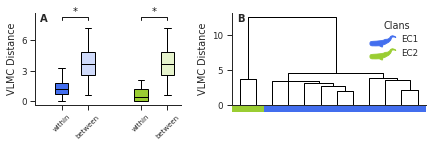

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(7, 1.7), width_ratios=[3, 4])


repertoires = dominica_repertoires
distances = dominica_distances
clans = np.unique([r.clan for r in repertoires])
values, positions, labels, stats = inner_outer(repertoires, distances)

h = 0.35
y = 8

bp = axs[0].boxplot(
    values,
    # labels=[label.split("_")[1] for label in labels],
    positions=positions,
    patch_artist=True,
)
for patch, label in zip(bp["boxes"], labels):
    if label.split("_")[1] == "between":
        patch.set(facecolor=desat_color[label.split("_")[0]])
    else:
        patch.set(facecolor=clan_color[label.split("_")[0]])

plt.setp(bp["medians"], color="black")
axs[0].set_ylabel("VLMC Distance")
axs[0].set_xlim(0, 5.5)
axs[0].set_yticks([0, 3, 6])
axs[0].set_xticklabels([label.split("_")[1] for label in labels],rotation=45,fontsize=7)

for i in range(1, 3 * len(clans) + 1, 3):
    axs[0].plot([i, i, i + 1, i + 1], [y, y + h, y + h, y], linewidth=1, color="k")
    axs[0].text((i + i + 1) * 0.5, y + h, "*", ha="center", va="bottom", color="k")

# axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 45)

#########
D = dominica_distances
V, row_indexes = getV(np.maximum(D, D.T), [clan_color[r.clan] for r in repertoires])
clans = np.unique([r.clan for r in repertoires])
hierarchy.set_link_color_palette(list(clan_color.values()))
dn = hierarchy.dendrogram(
    V, color_threshold=0.1, above_threshold_color="black", ax=axs[1], no_labels=True
)

plt.setp(axs[1].collections, lw=1)

# plot_stripe([r.clan for r in repertoires], clan_color, row_indexes, ax=axs[1])

clan_label = [r.clan for r in repertoires]
colors = [clan_color[clan] for clan in [clan_label[i] for i in row_indexes]]

max_width = len(row_indexes)

# axs[1].set_xlim(0, max_width)
# axs[1].set_ylim(0, 0.1)
for i, color in enumerate(colors):
    axs[1].add_patch(
        Rectangle(xy=(i * 10, -1), width=10, fc=color, lw=0, height=1, clip_on=False)
    )

###
for clan in clans:
    axs[1].scatter(
        [],
        [],
        color=clan_color[clan],
        label=clan,
        marker=get_marker(whale_svg),
        s=1000,
    )
    axs[1].legend(
        loc="upper right", ncol=1, bbox_to_anchor=(1, 1), title="Clans", frameon=False
    )
axs[1].set_ylabel("VLMC Distance")

sb.despine()
plt.subplots_adjust(wspace=0.3)

for n, ax in enumerate(axs):
    labs = ["A", "B"]
    ax.text(
        0.03, 0.99, labs[n], transform=ax.transAxes, weight="bold", ha="left", va="top"
    )

plt.savefig("Figures/figure_2.pdf", dpi=250, bbox_inches="tight")

## Pacific Plots

/home/leitao/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


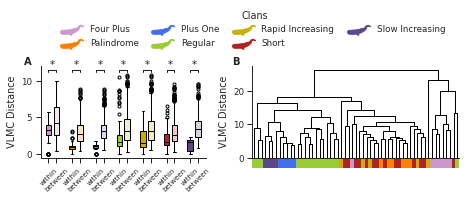

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 1.7), width_ratios=[4, 5])


repertoires = pacific_repertoires
distances = pacific_distances
clans = np.unique([r.clan for r in repertoires])
values, positions, labels, stats = inner_outer(repertoires, distances)
h = 0.35
y = 11.2

bp = axs[0].boxplot(
    values,
    # labels=[label.split("_")[1] for label in labels],
    positions=positions,
    patch_artist=True,
    flierprops={"markersize": 3},
    widths=0.7,
)
for patch, label in zip(bp["boxes"], labels):
    if label.split("_")[1] == "between":
        patch.set(facecolor=desat_color[label.split("_")[0]])
    else:
        patch.set(facecolor=clan_color[label.split("_")[0]])

plt.setp(bp["medians"], color="black")
axs[0].set_ylabel("VLMC Distance")
axs[0].set_xlim(0, 21)
# axs[0].set_yticks([0, 3, 6])
axs[0].set_xticklabels([label.split("_")[1] for label in labels])

for i in range(1, 22, 3):
    axs[0].plot([i, i, i + 1, i + 1], [y, y + h, y + h, y], linewidth=1, color="k")
    axs[0].text((i + i + 1) * 0.5, y + h, "*", ha="center", va="bottom", color="k")

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45,fontsize=7)

#########
D = pacific_distances
clans = np.unique([r.clan for r in repertoires])
V = hierarchy.linkage(squareform(np.maximum(D, D.T)), 'average')
dn = hierarchy.dendrogram(
    V, color_threshold=0.1, above_threshold_color="black", ax=axs[1],
)

plt.setp(axs[1].collections, lw=1)

# plot_stripe([r.clan for r in repertoires], clan_color, row_indexes, ax=axs[1])

clan_label = [r.clan for r in repertoires]
colors = [clan_color[pacific_repertoires[leaf_id].clan] for leaf_id in dn['leaves']]
#colors = [clan_color[clan] for clan in [clan_label[i] for i in row_indexes]]

max_width = len(row_indexes)

# axs[1].set_xlim(0, max_width)
# axs[1].set_ylim(0, 0.1)
for i, color in enumerate(colors):
    axs[1].add_patch(
        Rectangle(xy=(i * 10, -3), width=10, fc=color, lw=0, height=3, clip_on=False)
    )

###
for clan in clans:
    axs[0].scatter(
        [],
        [],
        color=clan_color[clan],
        label=clan_name[clan],
        marker=get_marker(whale_svg),
        s=800,
    )
    axs[0].legend(
        loc="center left",
        ncol=4,
        bbox_to_anchor=(0.1, 1.4),
        title="Clans",
        frameon=False,
    )

    axs[1].set_ylabel("VLMC Distance")


for n, ax in enumerate(axs):
    labs = ["A", "B"]
    ax.text(
        -0.1, 1.1, labs[n], transform=ax.transAxes, weight="bold", ha="left", va="top"
    )

sb.despine()
plt.subplots_adjust(wspace=0.25)

plt.savefig("Figures/figure_3.pdf", dpi=250, bbox_inches="tight")
plt.savefig("Figures/figure_3.png", dpi=250, bbox_inches="tight")

# Clan Overlap

In [16]:
def getClanTrees(clans,idcodas=True):
    """
    Get the subcoda tree for each pacific clan
    """
    coda_condition = paper_data['coda_type'].isin(flatten(identity_codas.values()))
    if not idcodas:
        coda_condition = ~coda_condition
    trees= []
    for clan in clans:
        clan_condition = paper_data['clan_name']==clan
        condition = coda_condition & clan_condition
        tree,_ = fitVlmc(paper_data[condition],click_col='nclicks')
        trees.append(tree)
    return trees

def overlapData(idcodas):
    """
    Calculating clan distance, making sure it has the same indexes
    as clan ovelap
    """
    overlap = pd.read_csv("Data/pacific_clan_overlap.csv")
    clanTrees = getClanTrees(overlap.columns,idcodas=idcodas)
    N = len(clanTrees)
    D = np.empty(shape=(N,N))
    for i in range(N):
        for j in range(N):
            D[i,j]=vlmc.distance(clanTrees[i],clanTrees[j])
    notDiag=~np.eye(N,dtype=bool)
    return overlap.values, D, notDiag #overlap.values[notDiag],D[notDiag]


def plot_overlap(xx,yy,ax=None, ms=None):
    """
    Auxiliary function for plotting overlap
    """
    for i,j in np.ndindex(len(xx),len(xx)):
        if i==j:
            continue
        marker_style = dict(color=clan_color[overlap.columns[i]], linestyle=':', marker='o',
                        markersize=ms, markerfacecoloralt=clan_color[overlap.columns[j]],
                           markeredgewidth=0)
        ax.plot(xx[i,j],yy[i,j],fillstyle="left", **marker_style)


overlap = pd.read_csv("Data/pacific_clan_overlap.csv")
xx, yid, mask = overlapData(idcodas=True)
xx, yNid, mask = overlapData(idcodas=False)

/home/leitao/anaconda3/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
/home/leitao/anaconda3/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(
/home/leitao/anaconda3/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child2), but could not find a label for it.
  warnings.warn(
/home/leitao/anaconda3/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child3), but could not find a label for it.
  warnings.warn(
/home/leitao/anaconda3/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child4), but could not find a label for it.
  warnings.warn(
/home/leitao/anaconda3/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(

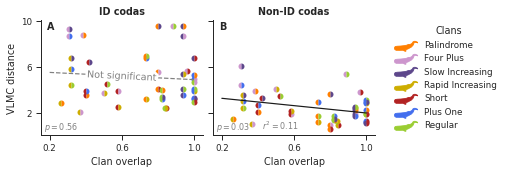

In [61]:
mosaic = """
AAABBB
AAABBB
AAABBB
"""

ms = 6

axs = plt.figure(figsize=(6, 2.1)).subplot_mosaic(mosaic, sharey=True, sharex=True)

plot_overlap(xx, yid, ax=axs["A"], ms=ms)
slope, intercept, r, p, se = linregress(xx[mask], yid[mask])
poly1d_fn = np.poly1d([slope, intercept])

axs["A"].plot(
    np.linspace(0.2, 1),
    poly1d_fn(np.linspace(0.2, 1)),
    color="gray",
    linestyle="--",
    label=f"Not significant",
)
labelLines(axs["A"].get_lines(), zorder=2.5)
axs["A"].annotate(
    text=f"$p = {p:.2f}$",
    xy=(0.02, 0.05),
    xycoords="axes fraction",
    fontsize="small",
    color="gray",
)
axs["A"].set_xlabel("Clan overlap")
axs["A"].set_ylabel("VLMC distance")
axs["A"].set_title("ID codas", weight="bold")


plot_overlap(xx, yNid, ax=axs["B"], ms=ms)
slope, intercept, r, p, se = linregress(xx[mask], yNid[mask])
poly1d_fn = np.poly1d([slope, intercept])
axs["B"].plot(
    np.linspace(0.2, 1),
    poly1d_fn(np.linspace(0.2, 1)),
    color="k",
    linestyle="-",
    # label=f"slope: {np.round(slope,2)}",
)
# labelLines(axs["B"].get_lines(), zorder=2.5)
axs["B"].annotate(
    text=f"$p = {p:.2f}$",
    xy=(0.02, 0.05),
    xycoords="axes fraction",
    fontsize="small",
    color="gray",
)
axs["B"].annotate(
    text=f"$r^2 = {np.square(r):.2f}$",
    xy=(0.3, 0.05),
    xycoords="axes fraction",
    fontsize="small",
    color="gray",
)
axs["B"].set_xlabel("Clan overlap")
# axs["B"].set_ylabel("Vlmc Distance")
axs["B"].set_title("Non-ID codas", weight="bold")

axs["A"].set_xticks([0.2, 0.6, 1])
axs["A"].set_yticks([2, 6, 10])


###

for clan in clan_color:#dont plot the dominica whales
    if clan =="EC1" or clan =="EC2":
        continue
    axs["B"].scatter(
        [],
        [],
        color=clan_color[clan],
        label=clan_name[clan],
        marker=get_marker(whale_svg),
        s=800,
    )
    axs["B"].legend(
        loc="center left",
        ncol=1,
        bbox_to_anchor=(1.1, 0.5),
        title="Clans",
        frameon=False,
    )


axs["B"].set_xlim(0.15, 1.05)
sb.despine()

for n, ax in enumerate(axs):
    labs = ["A", "B"]
    axs[ax].text(
        0.04,
        0.99,
        labs[n],
        transform=axs[ax].transAxes,
        weight="bold",
        ha="left",
        va="top"
    )

plt.savefig("Figures/figure_4.pdf", dpi=250, bbox_inches="tight")
plt.savefig("Figures/figure_4.png", dpi=250, bbox_inches="tight")

### Misc

In [15]:
import umap

/Users/maxime/.pyenv/versions/python_39/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/maxime/.pyenv/versions/python_39/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/maxime/.pyenv/versions/python_39/lib/python3.9/site-pac

/Users/maxime/.pyenv/versions/python_39/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


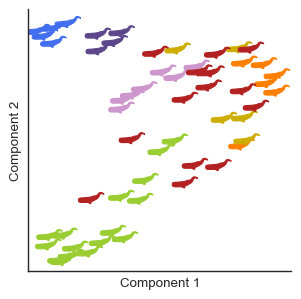

In [16]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))

embedding = umap.UMAP(metric="precomputed", random_state=42).fit_transform(
    np.maximum(pacific_distances, pacific_distances.T)
)
ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    color=[clan_color[r.clan] for r in pacific_repertoires],
    marker=get_marker(whale_svg),
    s=500,
)
ax.set_ylabel("Component 2")
ax.set_xlabel("Component 1")
ax.set_xticks([])
ax.set_yticks([])

sb.despine()

plt.savefig("Figures/pacific_scatterplot.png", dpi=250, bbox_inches="tight")
plt.savefig("Figures/pacific_scatterplot.pdf", dpi=250, bbox_inches="tight")

plt.show()

# Stats

In [76]:
#dominica:
values, positions, labels, stats = inner_outer(dominica_repertoires, dominica_distances)
print("DOMINICA STATS")
print_dict(stats)
print("\n")
#pacific:
values, positions, labels, stats = inner_outer(pacific_repertoires, pacific_distances)
print("PACIFIC STATS")
print_dict(stats)

DOMINICA STATS
ks_test              	t_test               	cohen_d            	clan
1.5e-16              	1e-24                	-2.4               	EC1
0.0019               	0.0006               	-1.9               	EC2


PACIFIC STATS
ks_test               	t_test                	cohen_d             	clan            
1.5e-11               	6.7e-13               	-0.69               	Four Plus       
9e-33                 	1.4e-18               	-1                  	Palindrome      
6e-26                 	1.7e-21               	-1.2                	Plus One        
2.2e-50               	7.6e-54               	-0.9                	Regular         
2.5e-09               	2.1e-10               	-0.82               	Rapid Increasing
7.7e-17               	1.8e-11               	-0.38               	Short           
6.3e-07               	7.8e-07               	-1.3                	Slow Increasing 


In [93]:
#one table for coda types
print(f"Clan name | Total | ID | non-ID | Percentage of ID")
agg_total_codas, agg_number_ID=0,0
avg_percentage = []
for clan, frame in paper_data.groupby('clan_name'):
    total_codas = frame[~frame["coda_type"].isna()]['coda_type'].unique().shape[0]
    agg_total_codas += total_codas
    number_ID = len(identity_codas[clan])
    agg_number_ID += number_ID
    number_nID = total_codas - number_ID
    percentage_ID = np.round(number_ID/total_codas*100,2)
    avg_percentage.append(number_ID/total_codas)
    print(f"{clan_name[clan]} ({clan}) | {total_codas} | {number_ID} | {number_nID}  |{percentage_ID}%")
    
print(f"Total | {agg_total_codas} | {agg_number_ID} | {agg_total_codas-agg_number_ID} |{np.round(agg_number_ID/agg_total_codas*100,2)}%")
print(f"Average Percentage: {np.mean(avg_percentage)*100}")

Clan name | Total | ID | non-ID | Percentage of ID
Four Plus (FP) | 72 | 2 | 70  |2.78%
Palindrome (PALI) | 64 | 9 | 55  |14.06%
Plus One (PO) | 54 | 6 | 48  |11.11%
Regular (REG) | 74 | 9 | 65  |12.16%
Rapid Increasing (RI) | 79 | 2 | 77  |2.53%
Short (SH) | 85 | 1 | 84  |1.18%
Slow Increasing (SI) | 59 | 3 | 56  |5.08%
Total | 487 | 32 | 455 |6.57%
Average Percentage: 6.986630424516925


In [94]:
#one table for coda counts
print(f"Clan name | Total | ID | non-ID | Percentage of ID")
agg_total_codas, agg_number_ID=0,0
avg_percentage = []
for clan, frame in paper_data.groupby('clan_name'):
    total_codas = frame.shape[0]
    agg_total_codas += total_codas
    number_ID = frame[frame['coda_type'].isin(identity_codas[clan])].shape[0]
    agg_number_ID += number_ID
    number_nID = total_codas - number_ID
    percentage_ID = np.round(number_ID/total_codas*100,2)
    avg_percentage.append(number_ID/total_codas)
    print(f"{clan_name[clan]} ({clan}) | {total_codas} | {number_ID} | {number_nID}  |{percentage_ID}%")
    
print(f"Total | {agg_total_codas} | {agg_number_ID} | {agg_total_codas-agg_number_ID} |{np.round(agg_number_ID/agg_total_codas*100,2)}%")
print(f"Average Percentage: {np.mean(avg_percentage)*100}")

Clan name | Total | ID | non-ID | Percentage of ID
Four Plus (FP) | 2590 | 587 | 2003  |22.66%
Palindrome (PALI) | 2124 | 1249 | 875  |58.8%
Plus One (PO) | 2083 | 1252 | 831  |60.11%
Regular (REG) | 8289 | 3545 | 4744  |42.77%
Rapid Increasing (RI) | 1776 | 425 | 1351  |23.93%
Short (SH) | 5428 | 562 | 4866  |10.35%
Slow Increasing (SI) | 1265 | 541 | 724  |42.77%
Total | 23555 | 8161 | 15394 |34.65%
Average Percentage: 37.341725136576834
